# Simple Renaming Workflow

In [1]:
from fileinput import filename
import os
import getpass
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from pydantic import Field, BaseModel
from langchain_core.prompts import ChatPromptTemplate
from typing import Optional, TypedDict

In [2]:
# Load environment variables from .env file
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

llm = ChatOpenAI(model="gpt-4o", temperature=0)

## Step 1: Create Agent State and Workflow

- Create an agent that does the following 
- Extracts all useful metadata
- Checks if a filename is valid, 
- If so, copy the file to the output directory 
- If not, renames the file, 
- Copies the file to the output directory.

In [3]:
class AgentState(TypedDict):
    filename: str
    is_valid: bool
    common_name: Optional[str]

In [4]:
def record_metadata_extractor(state: AgentState) -> AgentState:
    extractor_prompt = ChatPromptTemplate.from_template(
        """
        You are a tool that extracts species common names from image filename strings. 
        Examples of common names include "Antler Coral" and "Cauliflower Coral".
        
        Given the following filename, extract the common name of the coral species present in the image.
        If no common name can be determined, return None.
        
        Filename: {filename}
        """
    )
    
    print("Extracting common name from filename:", state["filename"])
    
    # Create the chain and invoke it
    chain = extractor_prompt | llm
    res = chain.invoke({"filename": state["filename"]})
    print("llm response:", res.content)
    
    # Update the state with extracted common name
    state["common_name"] = res.content.strip() if res.content.strip() != "None" else None
    
    return state

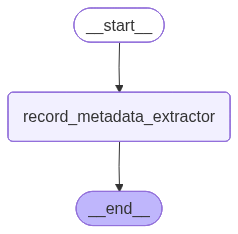

In [5]:
builder = StateGraph(AgentState)

builder.add_node("record_metadata_extractor", record_metadata_extractor)
builder.add_edge(START, "record_metadata_extractor")
builder.add_edge("record_metadata_extractor", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# Test the workflow with a sample filename
init_state = {
    "filename": "Antler Coral Pocillopora eydouxi entangled Hanauma Bay 20210421_25_Roberts_Anke - HAN.JPG",
    "is_valid": True,
    "common_name": None
}

result = graph.invoke(init_state)
print("Final result:", result)

Extracting common name from filename: Antler Coral Pocillopora eydouxi entangled Hanauma Bay 20210421_25_Roberts_Anke - HAN.JPG
llm response: Antler Coral
Final result: {'filename': 'Antler Coral Pocillopora eydouxi entangled Hanauma Bay 20210421_25_Roberts_Anke - HAN.JPG', 'is_valid': True, 'common_name': 'Antler Coral'}
